The purpose of this project is to predict the probability of customer churn of a telecommunications company. The quality metric will be ROC-AUC.

## First part. Data exploration

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
 
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
random_state = 42
test_size = 0.2

In [4]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3417,27,59.45,1611.65,Male,0,No,No,Yes,Yes,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,0
4871,1,55.55,55.55,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,0
220,2,70.95,137.95,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
1629,70,80.40,5717.85,Female,0,Yes,Yes,Yes,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),0
2129,37,96.10,3646.8,Male,0,No,No,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [6]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]
feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [7]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

A training dataset was received containing 5282 rows and 20 columns with data (where 4 columns, including the target, are of a numerical type, 16 are of a string type). There are no nan in the data.
The target attribute is the data in the 'Churn' column, which characterizes the data on whether the company's client left (0) or stayed (1), respectively, this task is a binary classification task.

## Data analysis

In [8]:
data.TotalSpent.replace(' ', 0, inplace=True)
data.TotalSpent = [float(x) for x in data.TotalSpent]

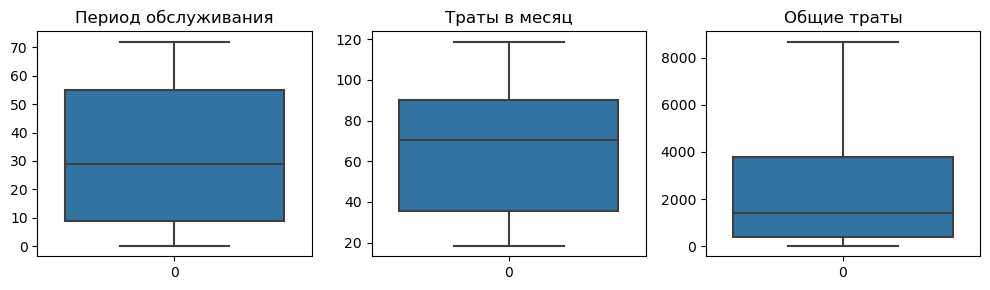

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
sns.boxplot(data=data.ClientPeriod, ax=axs[0]).set_title('Период обслуживания');
sns.boxplot(data=data.MonthlySpending, ax=axs[1]).set_title('Траты в месяц');
sns.boxplot(data=data.TotalSpent, ax=axs[2]).set_title('Общие траты');
fig.tight_layout()

In [10]:
fig = px.box(data.TotalSpent, height=350, width=350)
fig.show()
fig = px.box(data[num_cols].drop('TotalSpent', axis=1), height=350, width=350)
fig.show()

In the TotalSpen column, the data type has been changed (brought to a number with a dot) and the existing nan have been replaced with 0.
The distribution of numerical features is visualized using the Seaborn library. I also repeated the same operation using the Plotly library, which allows you to create interactive graphs, where you can see all the main characteristics of the distribution of features when you hover over the cursor.
So, all three features are not evenly distributed (this is especially noticeable in cases of spending: monthly spending is skewed to the left, and common to the right, which indicates that more users spend less per month, and in total - more than the median value) .

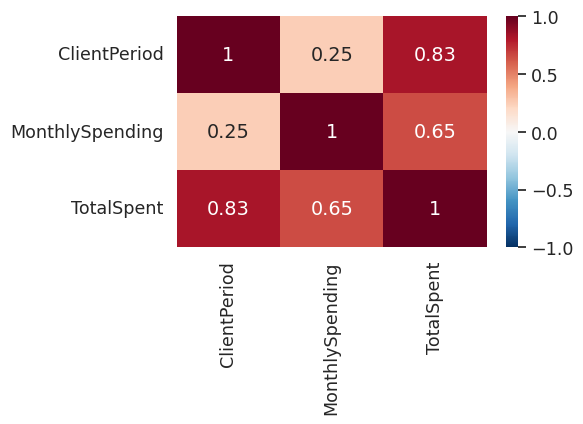

In [11]:
sns.set(font_scale=1.15)
plt.figure(figsize=(5,3))
sns.heatmap(
    data[num_cols].corr(),        
    cmap='RdBu_r', 
    annot=True,
    vmin=-1, vmax=1);

It is noticeable that there is a strong correlation between the features in the columns with the service period and total expenses, which is quite logical)

To make the visualization more "watchable" I will divide the categorical features into several parts and draw conclusions for each. In pie charts, amounts of categorical data will be presented as a percentage.

In [12]:
data[['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild']].value_counts().to_frame(name='Итого:')

Итого:
Sex    IsSeniorCitizen HasPartner HasChild        
Male   0               No         No          1007
Female 0               No         No          1005
                       Yes        Yes          636
Male   0               Yes        Yes          629
Female 0               Yes        No           463
Male   0               Yes        No           422
Female 1               No         No           224
Male   1               Yes        No           217
                       No         No           184
       0               No         Yes          161
Female 1               Yes        No           154
       0               No         Yes          117
Male   1               Yes        Yes           31
Female 1               Yes        Yes           25
Male   1               No         Yes            4
Female 1               No         Yes            3

Based on the above personal data, it is possible to draw up a portrait of a typical user: this is a man or a woman (equally), young, without a family and children, while the least used services: an elderly person without a partner, but with children (gender is again distributed in equally.) It is also worth noting that all these signs are binary.

Distribution of personal data of users


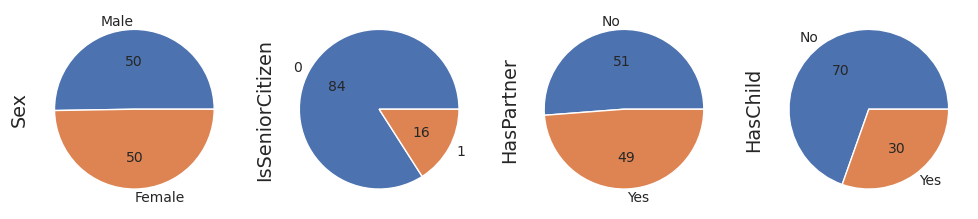

In [13]:
print('Distribution of personal data of users')
fig, axs = plt.subplots(ncols=4, figsize=(10, 3))
autopct='%.0f'
font_size=10
data.Sex.value_counts().plot.pie(autopct=autopct,fontsize=font_size, ax=axs[0])
data.IsSeniorCitizen.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1])
data.HasPartner.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[2])
data.HasChild.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[3])
fig.tight_layout()

In [14]:
data[['HasPhoneService', 'HasMultiplePhoneNumbers', 'HasContractPhone']].value_counts()\
    .to_frame(name='Итого:')

Итого:
HasPhoneService HasMultiplePhoneNumbers HasContractPhone        
Yes             No                      Month-to-month      1505
                Yes                     Month-to-month      1123
                                        Two year             670
                No                      One year             520
                                        Two year             486
                Yes                     One year             457
No              No phone service        Month-to-month       292
                                        Two year             124
                                        One year             105

Telephony Data Distribution


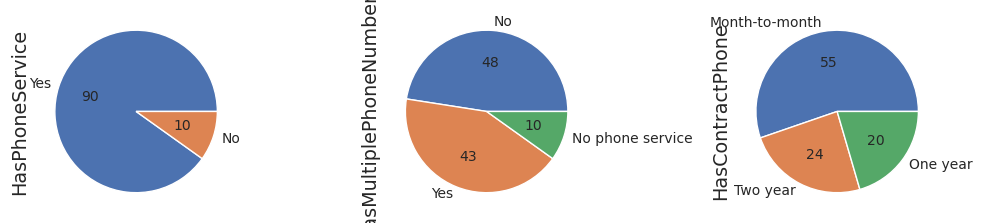

In [15]:
print('Telephony Data Distribution')
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
autopct='%.0f'
font_size=10
data.HasPhoneService.value_counts().plot.pie(autopct=autopct,fontsize=font_size, ax=axs[0])
data.HasMultiplePhoneNumbers.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1])
data.HasContractPhone.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[2])
fig.tight_layout()

So: most customers use the phone, having a monthly payment agreement. The distribution of the MultiplePhoneNumbers function is relatively even, with a slight skew towards its absence.

In [16]:
data[['HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess']].value_counts().to_frame(name="Итого:")

Итого:
HasInternetService HasOnlineSecurityService HasOnlineBackup     HasDeviceProtection HasTechSupportAccess        
No                 No internet service      No internet service No internet service No internet service     1141
Fiber optic        No                       No                  No                  No                       641
DSL                No                       No                  No                  No                       308
Fiber optic        No                       No                  Yes                 No                       247
                                            Yes                 No                  No                       239
DSL                Yes                      Yes                 Yes                 Yes                      207
Fiber optic        No                       Yes                 Yes                 No                       206
                   Yes                      Yes                 Yes                 Yes                      147
DSL                Yes                      No                  Yes                 Yes                      133
                                                                No                  No                       124
Fiber optic        Yes                      No                  No                  No                       112
DSL                No                       Yes                 No                  No                       110
                   Yes                      Yes                 No                  Yes                      108
Fiber optic        No                       Yes                 Yes                 Yes                      106
                                            No                  Yes                 Yes                      106
DSL                No                       No                  No                  Yes                      105
Fiber optic        Yes                      Yes                 Yes                 No                        98
DSL                Yes                      No                  No                  Yes                       98
                   No                       No                  Yes                 No                        91
                   Yes                      Yes                 Yes                 No                        84
Fiber optic        Yes                      Yes                 No                  No                        84
                   No                       Yes                 No                  Yes                       81
DSL                No                       No                  Yes                 Yes                       80
                                            Yes                 Yes                 Yes                       80
                                                                No                  Yes                       77
Fiber optic        No                       No                  No                  Yes                       76
DSL                Yes                      Yes                 No                  No                        74
Fiber optic        Yes                      No                  Yes                 No                        65
DSL                Yes                      No                  Yes                 No                        62
                   No                       Yes                 Yes                 No                        59
Fiber optic        Yes                      No                  Yes                 Yes                       53
                                            Yes                 No                  Yes                       49
                                            No                  No                  Yes                       31

Distribution of data regarding the use of Internet services


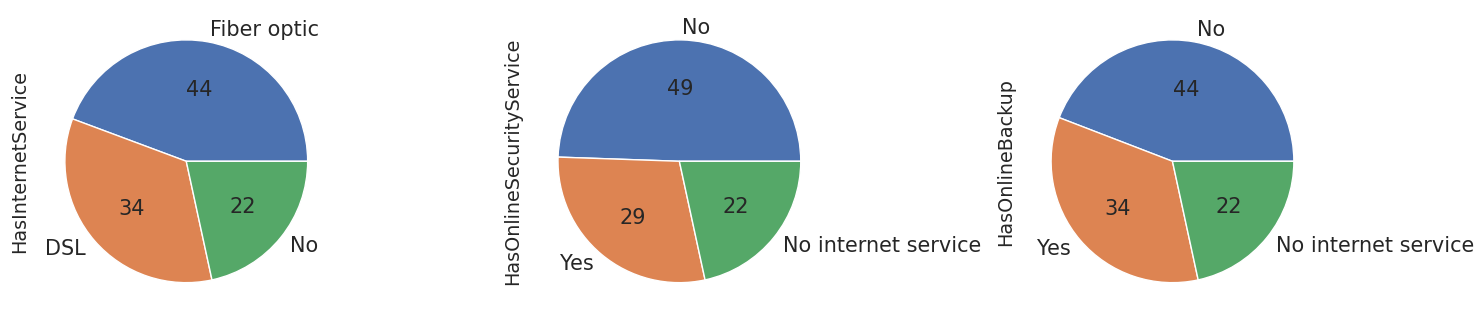

In [17]:
print('Distribution of data regarding the use of Internet services')
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 10))
autopct='%.0f'
font_size=15
data.HasInternetService.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[0])
data.HasOnlineSecurityService.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1])
data.HasOnlineBackup.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[2])

fig.tight_layout()

Distribution of data regarding the use of Internet services


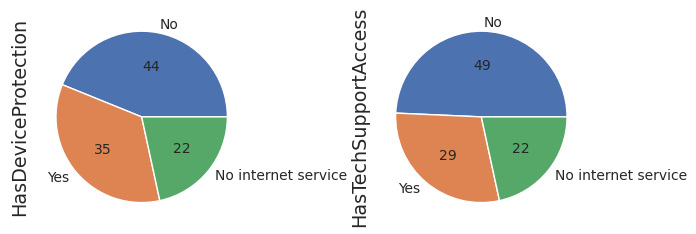

In [18]:
print('Distribution of data regarding the use of Internet services')
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 3))
autopct='%.0f'
font_size=10
data.HasDeviceProtection.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[0])
data.HasTechSupportAccess.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1])
fig.tight_layout()

Conclusions regarding Internet services:
- most clients use the Internet (Fiber optic prevails), do not use OnlineSecurityService, do not have OnlineBackup, DeviceProtection and TechSupportAccess.

In [19]:
data[['HasOnlineTV', 'HasMovieSubscription']].value_counts().to_frame(name='Итого:')

,,Итого:
HasOnlineTV,HasMovieSubscription,
No,No,1520
Yes,Yes,1481
No internet service,No internet service,1141
No,Yes,579
Yes,No,561


Distribution of data regarding the use of Internet TV


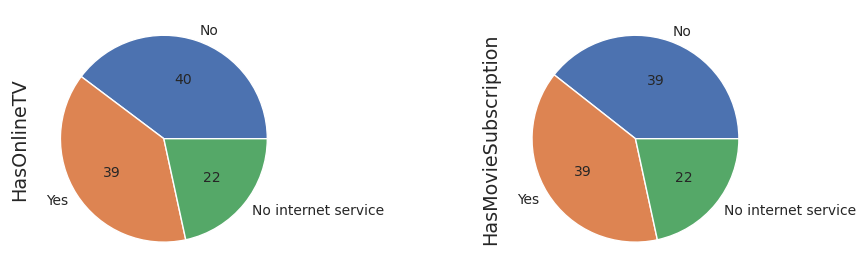

In [20]:
print('Distribution of data regarding the use of Internet TV')
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))
autopct='%.0f'
font_size=10
data.HasOnlineTV.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[0])
data.HasMovieSubscription.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1])

fig.tight_layout()

In [21]:
data[['IsBillingPaperless', 'PaymentMethod']].value_counts().to_frame()

0
IsBillingPaperless PaymentMethod                  
Yes                Electronic check           1312
No                 Mailed check                711
Yes                Bank transfer (automatic)   688
                   Credit card (automatic)     665
                   Mailed check                483
No                 Credit card (automatic)     478
                   Electronic check            474
                   Bank transfer (automatic)   471

Distribution of data regarding the process of payment for services


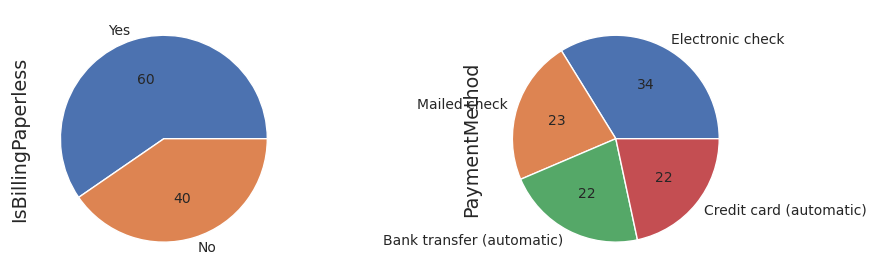

In [22]:
print('Distribution of data regarding the process of payment for services')
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))
autopct='%.0f'
font_size=10
data.IsBillingPaperless.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[0])
data.PaymentMethod.value_counts().plot.pie(autopct=autopct, fontsize=font_size, ax=axs[1])
fig.tight_layout()

Total:
- Internet TV and MovieSubscription service are not used by the majority of clients;
- customers receive mainly electronic checks and pay for services with electronic checks.

In [23]:
data[target_col].value_counts().to_frame(name='Итого:')

,Итого:
0,3898
1,1384


In this case, there is an imbalance in the target class (class "0" is almost 3 times more than the amount of data with class "1").

## Application of linear models

First, I will prepare the features for training, encode the categorical features, and normalize the features using the Standard Scaler. Then I will train the logistic regression model and show the level of the resulting quality metric on the validation set.

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(data[feature_cols], data[target_col],
 test_size=test_size, random_state=random_state)

In [25]:
oe = OrdinalEncoder()
oe.fit(X_train[cat_cols])
new_columns = oe.get_feature_names_out(X_train[cat_cols].columns)
X_train_oe = pd.DataFrame(oe.transform(X_train[cat_cols]), columns=new_columns,
    index=X_train[cat_cols].index)
X_valid_oe = pd.DataFrame(oe.transform(X_valid[cat_cols]), columns=new_columns,
    index=X_valid[cat_cols].index)

In [26]:
X_train = pd.concat([X_train_oe, X_train[num_cols]], axis=1)
X_valid = pd.concat([X_valid_oe, X_valid[num_cols]], axis=1)

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns,
 index=X_train.index)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns,
 index=X_valid.index)

In [28]:
model = LogisticRegressionCV(cv=5, refit=True, scoring='roc_auc')
model.fit(X_train, y_train)
roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])

0.8281600650160231

In [29]:
model = LogisticRegression(random_state=random_state)
parametrs = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 200]}
grid = GridSearchCV(model, parametrs, scoring='roc_auc')
grid.fit(X_train, y_train)
grid.best_params_

{'C': 100}

In [30]:
roc_auc_score(y_valid, grid.best_estimator_.predict_proba(X_valid)[:,1])

0.8281369769396294

The logistic regression model achieved the best ROC-AUC metric of 0.828, with hyperparameter C = 100.

## Applying Gradient Boosting

In this section, the CatBoostClasifier model will be used for prediction, there is no need to encode data for this model. I will get the quality metric on the test sample using the cross_validate method, then I will select the hyperparameters of the model.

In [31]:
X = data[feature_cols]
y = data[target_col]

In [32]:
index = []
scores = {"ROC-AUC": []}
scoring = ["roc_auc"]

In [33]:
cat_clf = CatBoostClassifier(random_state=random_state, eval_metric='AUC',
                             cat_features=cat_cols, verbose=0)
index += ["CatBoost"]
cv_result = cross_validate(cat_clf, X, y, scoring=scoring)
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,ROC-AUC
CatBoost,0.842705


In [34]:
model = CatBoostClassifier(n_estimators=400, max_depth=3, random_state=random_state,
                    eval_metric='AUC', l2_leaf_reg=0.005,
                    cat_features=cat_cols, verbose=0)
model.fit(X, y)
y_train_predicted = model.predict_proba(X)[:, 1]

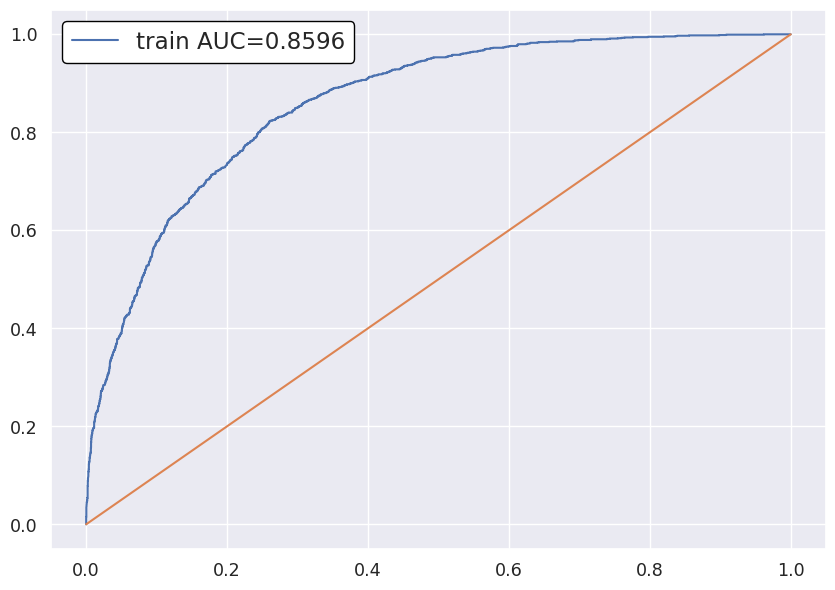

In [35]:
train_auc = roc_auc_score(y, y_train_predicted)


plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [37]:
test.TotalSpent.replace(' ', 0, inplace=True)
test.TotalSpent = [float(x) for x in test.TotalSpent]

In [38]:
X_test = test[feature_cols]

In [39]:
probs = model.predict_proba(X_test)[:, 1]

In [40]:
sub = pd.DataFrame({'Id': test.index, 'Churn': probs})
sub

,Id,Churn
0,0,0.026120
1,1,0.658460
2,2,0.625398
3,3,0.018300
4,4,0.006561
...,...,...
1756,1756,0.133097
1757,1757,0.014780
1758,1758,0.777314
1759,1759,0.497405
